# Unsupervised learning with a Graph-convolutional auto-encoder

## Imports and setup

In [1]:
import itertools

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Wedge, Circle
from matplotlib.text import Text
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Network drawing routines

In [2]:
BORDER_PROP = .2
RADIUS_GAP = .2
THETA_GAP = .05

def inner_repeat(it, n):
    return itertools.chain(*zip(*itertools.tee(it, n)))

def nodes_patches(layout, labels, training_nodes=[], radius=.04):
    titles, xys = zip(*sorted(layout.items()))
    
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette_border = np.array(sb.color_palette(n_colors=labels.shape[1]))
    palette_circle = np.array(sb.color_palette(n_colors=labels.shape[1]))

    # Create wedges
    wedges = []
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for i, (xy, theta1, theta2) in enumerate(zip(inner_repeat(xys, labels.shape[1]),
                                                 thetas1.flat, thetas2.flat)):
        wedges.append(Wedge(xy, radius,
                            theta1 * 360, theta2 * 360,
                            width=BORDER_PROP * radius,
                            color=palette_border[i % labels.shape[1]]))
    
    # Create central circles and titles
    circles = []
    texts = []
    color_predictions = palette_circle[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for xy, color, title in zip(xys, color_predictions, titles):
        circles.append(Circle(xy, radius * (1 - BORDER_PROP - RADIUS_GAP), color=color))
        texts.append(Text(x=xy[0], y=xy[1], text=str(title),
                          va='center', ha='center',
                          color='white', # if np.mean(color) >= .5 else 'black',
                          #fontsize=radius * 100)
                          ))
    
    return wedges + circles, texts

def update_nodes_patches(patches, labels, training_nodes=[]):
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette = np.array(sb.color_palette(n_colors=labels.shape[1]))
    
    # Extract wedges and circles
    wedges = list(filter(lambda p: isinstance(p, Wedge), patches))
    assert len(wedges) == np.prod(labels.shape)
    circles = list(filter(lambda p: isinstance(p, Circle), patches))
    assert len(circles) == labels.shape[0]
    
    # Update wedges
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for theta1, theta2, wedge in zip(thetas1.flat, thetas2.flat, wedges):
        wedge.set_theta1(theta1 * 360)
        wedge.set_theta2(theta2 * 360)
    
    # Update circles
    color_predictions = palette[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for circle, color in zip(circles, color_predictions):
        circle.set_color(color)

_network_layouts = {}
def draw_network(g, labels=None, training_nodes=[], ax=None, relayout=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.figure
    
    if relayout or g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if labels is None:
        assert len(training_nodes) == 0
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_patches = None
        edge_collection = None
        text_items = None
    else:
        # Plot nodes, edges and labels
        node_patches, text_items = nodes_patches(layout, labels, training_nodes=training_nodes)
        for artist in itertools.chain(node_patches, text_items):
            ax.add_artist(artist)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, edge_color='grey', ax=ax)
        
        # Add the colorbar
        #color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lmin, vmax=lmax))
        #color_sm.set_array([])
        #fig.colorbar(color_sm)
    
    xs, ys = np.array(list(layout.values())).T
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), aspect='equal')
    return (fig, ax), (node_patches, edge_collection, text_items)

### Model drawing routines

In [3]:
def plot_ξ_distribution(glk, q_model, features):
    g, l, k = glk
    palette = np.concatenate([np.array(sb.color_palette(n_colors=l)),
                              .5 * np.ones((l, 1))],
                             axis=1)
    communities = ([[i] for i in range(l)] * np.ones((l, k), dtype=np.int32)).reshape(-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))#, sharex=True, sharey=True)

    q_pred = q_model.predict(features, batch_size=len(features))

    # KDE plots
    q_pred_ξ_sample = K.eval(codecs.Gaussian(q_pred).stochastic_value(100))
    for i in range(l):
        x = q_pred_ξ_sample[i * k:(i + 1) * k, :, 0].flatten()
        y = q_pred_ξ_sample[i * k:(i + 1) * k, :, 1].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[i], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax1)
    ax1.set_title(r'$\xi$ density for each community (flat nodes+sampling)')
    
    # μ plots
    q_pred_μ = q_pred[:, :2].T
    ax2.scatter(q_pred_μ[0], q_pred_μ[1], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ.T):
        ax2.text(x, y, str(i), ha='center', va='center', color='white')
    ax2.set_title(r'$\mu = \left<\xi\right>$ for each node')
    
    # Box representing the μ plots in the KDE plots
    ax1.hlines(ax2.get_ylim(), *ax2.get_xlim(), colors='lightgrey')
    ax1.vlines(ax2.get_xlim(), *ax2.get_ylim(), colors='lightgrey')

## Test graphs

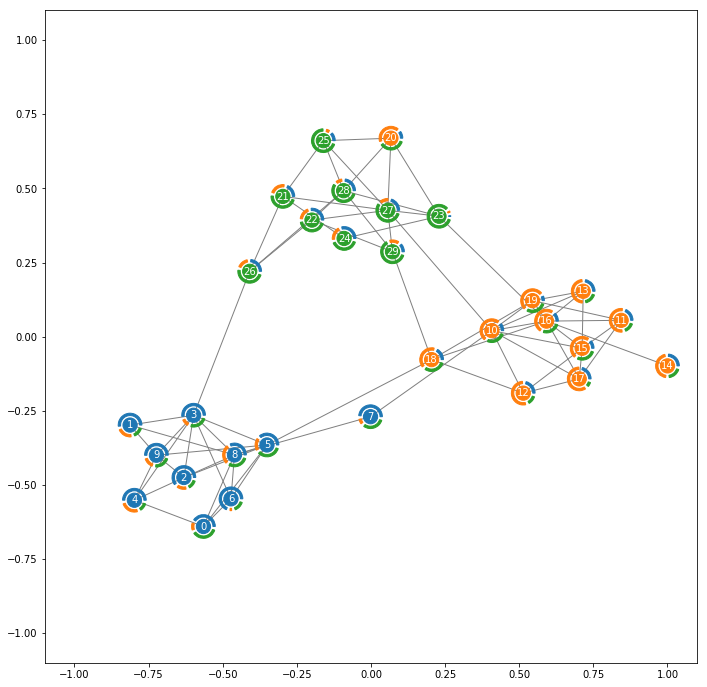

In [4]:
# Parameters
l = 3
k = 10
p_in = .4
p_out = .01
g = nx.planted_partition_graph(l, k, p_in, p_out)

# Show the graph
labels = np.zeros((l * k, l), dtype=np.float32)
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
#features = np.random.random((l * k, l)).astype(np.float32)
features = labels + np.abs(np.random.normal(loc=0.0, scale=.6, size=(l * k, l))).astype(np.float32)
draw_network(g, labels=features);

In [5]:
# Build the VAE
n_nodes = l * k
adj = nx.adjacency_matrix(g).todense().astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = l, 10, 2
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

# Encoder
q_input = keras.layers.Input(batch_shape=(n_nodes, dim_data), name='q_input')
q_layer1 = layers.GC(dim_l1, adj,
                     use_bias=use_bias,
                     activation='relu',
                     name='q_layer1')(q_input)
q_μ_flat = layers.GC(dim_ξ, adj,
                     use_bias=use_bias,
                     name='q_mu_flat')(q_layer1)
q_logD_flat = layers.GC(dim_ξ, adj,
                        use_bias=use_bias,
                        name='q_logD_flat')(q_layer1)
q_u_flat = layers.GC(dim_ξ, adj,
                     use_bias=use_bias,
                     name='q_u_flat')(q_layer1)
q_μlogDu_flat = keras.layers.Concatenate(name='q_mulogDu_flat')([q_μ_flat, q_logD_flat, q_u_flat])
q_model = keras.models.Model(inputs=q_input, outputs=q_μlogDu_flat)

# Decoder
p_input = keras.layers.Input(shape=(dim_ξ,), name='p_input')
p_layer1 = keras.layers.Dense(dim_l1,
                              use_bias=use_bias,
                              activation='relu',
                              kernel_regularizer='l2', bias_regularizer='l2',
                              name='p_layer1')(p_input)
p_adj = layers.Bilinear(0, adj.shape[0],
                        use_bias=use_bias,
                        #fixed_kernel=np.eye(dim_ξ),
                        kernel_regularizer='l2', bias_regularizer='l2',
                        name='p_adj')([p_layer1, p_layer1])
#p_v_μ_flat = keras.layers.Dense(dim_data,
#                                use_bias=use_bias,
#                                kernel_regularizer='l2', bias_regularizer='l2',
#                                name='p_v_mu_flat')(p_layer1)
#p_v_logD_flat = keras.layers.Dense(dim_data,
#                                   use_bias=use_bias,
#                                   kernel_regularizer='l2', bias_regularizer='l2',
#                                   name='p_v_logD_flat')(p_layer1)
#p_v_u_flat = keras.layers.Dense(dim_data,
#                                use_bias=use_bias,
#                                kernel_regularizer='l2', bias_regularizer='l2',
#                                name='p_v_u_flat')(p_layer1)
#p_v_μlogDu_flat = keras.layers.Concatenate(name='p_v_mulogDu_flat')(
#    [p_v_μ_flat, p_v_logD_flat, p_v_u_flat])
p_model = keras.models.Model(inputs=p_input,
                             outputs=[
                                 p_adj,
                                 #p_v_μlogDu_flat
                             ])

# Actual VAE
vae, vae_codecs = ae.build_vae(
    adj,
    (q_model, ('Gaussian',)),
    (p_model, (
        'SigmoidBernoulli',
        #codecs.Gaussian
    )),
    n_ξ_samples,
    [
        1.0,  # q loss
        1.0, # p adj loss
        #1.0  # p v loss
    ]
)

Overall model


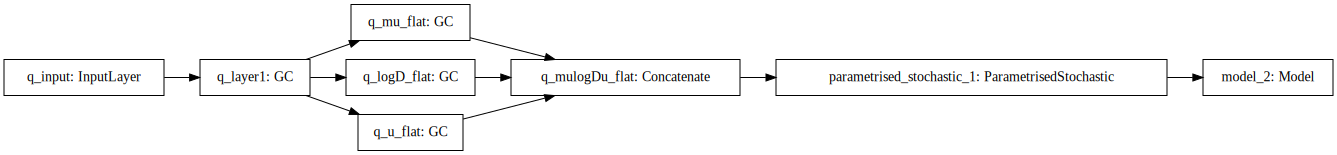

model_2


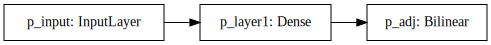

In [6]:
print('Overall model')
display(SVG(model_to_dot(vae, rankdir='LR').create(prog='dot', format='svg')))

for layer in vae.layers:
    if not isinstance(layer, keras.Model):
        continue
    print(layer.name)
    display(SVG(model_to_dot(layer, rankdir='LR').create(prog='dot', format='svg')))

**Before training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

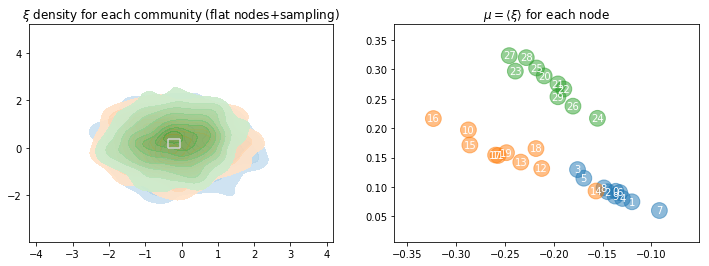

In [7]:
plot_ξ_distribution((g, l, k), q_model, utils.scale_center(features))

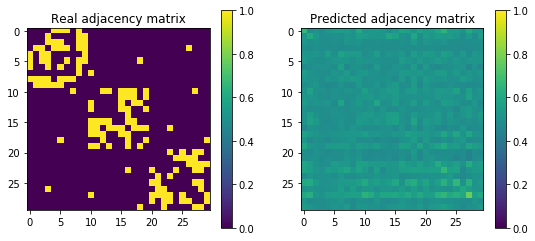

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(scipy.special.expit(vae.predict(utils.scale_center(features), batch_size=len(features))[1].mean(axis=1)[0]))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

**Train**

In [9]:
rm -r ./logs

In [10]:
n_epochs = 5000
vae.fit(x=utils.scale_center(features),
        y=[
            np.zeros((n_nodes, dim_ξ)),
            utils.expand_dims_tile(utils.expand_dims_tile(
                adj + np.eye(adj.shape[0]),
                0, n_ξ_samples), 0, n_nodes),
            #utils.expand_dims_tile(utils.scale_center(features), -2, n_ξ_samples)
        ],
        epochs=n_epochs, batch_size=n_nodes,
        verbose=0,
        callbacks=[
            keras.callbacks.TensorBoard()
        ])

**After training:** $\xi$ averages and distributions for each community, real and predicted adjacency matrices

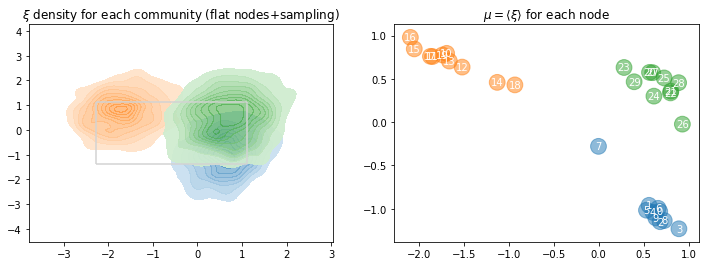

In [11]:
plot_ξ_distribution((g, l, k), q_model, utils.scale_center(features))

Predicted adjacency matrix:

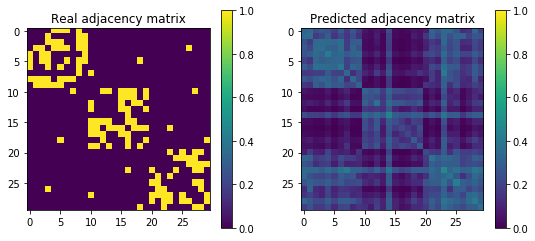

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(scipy.special.expit(vae.predict(utils.scale_center(features), batch_size=len(features))[1].mean(axis=1)[0]))
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

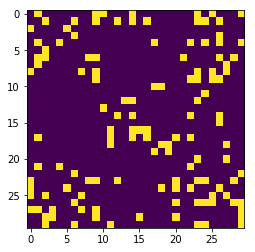

In [13]:
plt.imshow(np.random.binomial(1, scipy.special.expit(vae.predict(utils.scale_center(features), batch_size=len(features))[1].mean(axis=1)[0])))

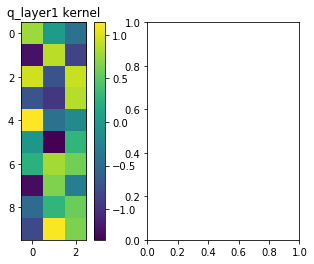

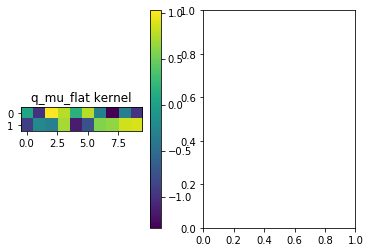

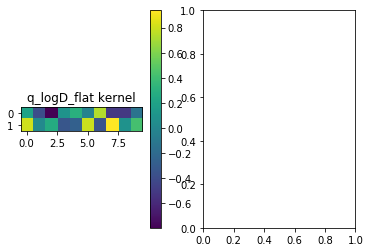

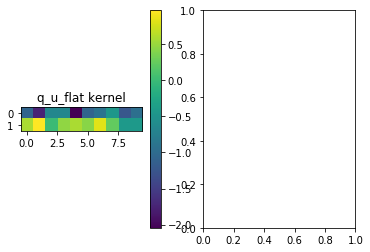

In [15]:
for layer in q_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)

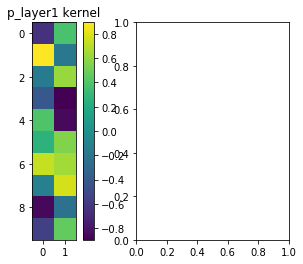

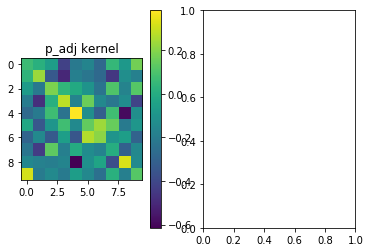

In [16]:
for layer in p_model.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)